# How important is the reservoir time constant?

A time-like ($τ$) parameter is available both in the data generator (sampling_step) and the reservoir ($α \sim 1/τ$). Wouldn't they dominate the quality of prediction?

Feb 15: No clear answer, but we need to troubleshoot other aspects of this model, before returning to this one. For now it's just too noisy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from echo import esn
import time

......./......./......./......./......./......./......./
Elapsed: 133.74 s


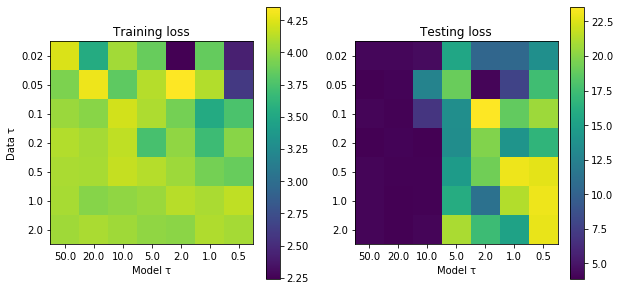

In [7]:
data = esn.Data.create_source('lorenz')

points_to_skip = 300
training_signal_length = 20000
test_length = 200
n_nodes = 200

taus = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]) # Different time constants

loss = np.zeros((len(taus), len(taus), 2)) # Training and testing losses

t = time.time()
for i in range(len(taus)): # Data
    for j in range(len(taus)): # Model
        model = esn.Reservoir(n_nodes, alpha=1/taus[j]) # Some empirical scaling

        seed = np.random.uniform()
        x,y = data.generate(points_to_skip + training_signal_length, sampling_step=taus[i], seed=seed)
        model.fit(x, y, skip=points_to_skip)

        # Training data loss    
        z = model.predict(x, length=points_to_skip+test_length)     
        loss[i,j,0] = esn.utils.loss(y[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])

        # Now generate new data, predict on it, calculate testing loss
        seed = np.random.uniform()
        x,y = data.generate(2000, sampling_step=taus[i], seed=seed)
        z = model.predict(x, length=points_to_skip+test_length)     
        loss[i,j,1] = esn.utils.loss(y[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])

        print('.', end='')
    print('/', end='')

print(f'\nElapsed: {time.time() - t:4.2f} s')

    
taus = np.round(taus, 4)
plt.figure(figsize=(10,5));
plt.subplot(121);
plt.imshow(np.log(loss[:,:,0]));
plt.title('Training loss');
plt.xticks(ticks=range(len(taus)), labels=1/taus)
plt.yticks(ticks=range(len(taus)), labels=taus)
plt.ylabel('Data τ')
plt.xlabel('Model τ')
plt.colorbar();
plt.subplot(122);
plt.imshow(np.log(loss[:,:,1]));
plt.title('Testing loss');
plt.xticks(ticks=range(len(taus)), labels=1/taus)
plt.yticks(ticks=range(len(taus)), labels=taus)
plt.colorbar();
plt.xlabel('Model τ');